# **PneumoniaMNIST with Quanvolution 2×2 and a Convolutional Neural Network**
### *Universidad Nacional Autónoma de México*
## Laboratorio Avanzado de Procesamiento de Imágenes
Académicos:
* Dr. Boris Escalante Ramírez

### Autor: **Sebastián González Juárez**

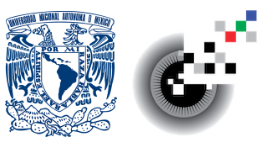

### **Resumen.**

En este proyecto armo mi primer QCNN y la comparo con una CNN clásica aplicadas a PneumoniaMNIST. Durante el entrenamiento, ambos modelos convergieron bien, pero la QCNN mostró una caída de pérdida más estable y un val_loss ligeramente menor, lo que indica una mejor generalización. En test, la QCNN también obtuvo mejores métricas globales (mayor accuracy y F1, y mejor equilibrio precisión–recall) especialmente cuando se usa su umbral óptimo, mientras que la CNN clásica mostró un comportamiento más variable y sensible al threshold.

Además, el análisis de los canales cuánticos y la evolución de los parámetros del ansatz confirmó que la parte cuántica sí aprende: los canales se vuelven más coherentes entre épocas y los parámetros evolucionan suavemente sin inestabilidades. Esto sugiere que la capa cuántica aporta una representación distinta a la clásica y podría aprovecharse aún más ampliando el ansatz o la estructura del circuito.

**Nota:** Recomiendo leer los códigos antecedentes para tener mejor contexto del camino al que voy y el avance que he dado. En los otros proyectos encontrarás mejores explicaciones que en el presente, pues la finalidad no fue explicar cada sección a detalle la cuál ya he dado explicaciones anteriormente. Espero para el proximo proyecto traer la explicación más desarrollada que englobe toda la carpeta. 

## **0) Imports, configuración básica y dispositivo**

En esta primera sección preparo el entorno de trabajo. Importo todas las librerías que voy a usar (PyTorch, PennyLane, MedMNIST, etc.), fijo semillas aleatorias para que los resultados sean lo más reproducibles posible y detecto si tengo GPU disponible. También ajusto la configuración de PyTorch para trabajar con float32 y activar optimizaciones en las convoluciones. Tal cual lo mismo del código pasado. 

| Elemento            | Papel en el notebook                                                           |
| ------------------- | ------------------------------------------------------------------------------ |
| `imports`           | Traer PyTorch, MedMNIST, PennyLane, sklearn, etc.                              |
| semillas (`SEED`)   | Controlar la aleatoriedad (Python, NumPy, Torch, CUDA).                        |
| `DEVICE`            | Elegir automáticamente entre `cuda:0` o `cpu`.                                 |
| configuración Torch | Tipo por defecto `float32` y activación de `cudnn.benchmark` para acelerar CNN |

In [1]:
import os, time, math, random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from torchvision import transforms
from medmnist import PneumoniaMNIST

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    f1_score
)

import pennylane as qml

#  Semillas: fijo una semilla global para controlar la aleatoriedad
SEED = 87
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Dispositivo: detecto si hay GPU disponible; en caso contrario uso CPU
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Trabajo en float32 en todo el código para evitar inconsistencias
torch.set_default_dtype(torch.float32)

# Activo optimizaciones de cuDNN para acelerar las convoluciones
torch.backends.cudnn.benchmark = True

print("Using device:", DEVICE)

Using device: cuda:0


## **1) Hiperparámetros**

En esta sección concentro todos los hiperparámetros del experimento. Aquí ajusto:
- Los parámetros generales de entrenamiento (tamaño de batch, número de épocas, tasa de aprendizaje, regularización).
- La configuración cuántica (tamaño de parche, número de qubits y capas del ansatz).
- Detalles del método de diferenciación que usa PennyLane sobre el backend default.qubit.torch.
- Parámetros de regularización como dropout y la dimensión de salida (un solo logit para clasificación binaria).

Nuevamente, no hay gran cambio de los notebooks pasados y en resumen:

| Nombre       | Significado                                                     |
| ------------ | --------------------------------------------------------------- |
| `BATCH_SIZE` | Número de imágenes por batch durante entrenamiento y validación |
| `EPOCHS`     | Cuántas pasadas completas doy al conjunto de entrenamiento      |
| `LR`         | Tasa de aprendizaje del optimizador Adam                        |
| `PATCH_SIZE` | Tamaño del parche cuántico (2x2)                                |
| `QUBITS`     | Número de qubits del circuito (uno por pixel del parche)        |
| `LAYERS`     | Número de capas del ansatz cuántico                             |
| `DROPOUT_P`  | Probabilidad de apagar neuronas en la cabeza clásica            |
| `OUT_DIM`    | Dimensión de la salida: 1 logit para neumonía vs sano           |

In [2]:
# Etiquetas de la tarea binaria: sano vs neumonía
CLASS_POS = 1  # neumonía
CLASS_NEG = 0  # sano

# Parámetros de entrenamiento
BATCH_SIZE   = 64
EPOCHS       = 20
LR           = 3.5e-5
WEIGHT_DECAY = 1e-5  # regularización L2 para las redes clásicas

# Configuración del bloque cuántico (quanvolution 2x2)
PATCH_SIZE = 2
QUBITS     = PATCH_SIZE * PATCH_SIZE  # 4 qubits, uno por pixel del parche 2x2
LAYERS     = 2  # profundidad del ansatz cuántico

# Configuración de PennyLane
DIFF_METHOD = "backprop"  # diferenciación basada en PyTorch
SHOTS       = None        # simulación analítica (sin muestreo)

# Parámetros de la cabeza clásica
DROPOUT_P = 0.20
OUT_DIM   = 1  # logit binario (antes de la sigmoide)

## **2) Preparación y carga de datos**

En esta parte cargo el dataset PneumoniaMNIST y lo convierto a tensores de PyTorch. Luego construyo tres DataLoaders (train, validación y test) con la misma lógica que he usado en otros notebooks, pero cuidando que el generador de aleatoriedad del DataLoader viva en CPU para evitar problemas cuando se usan varios workers. (Pues tuve algunos problemas)

También visualizo algunas imágenes de ejemplo para asegurarme de que los datos se vean razonables como lo hice en los demás notebooks.

Pequeño resumen:

| Objeto                       | Descripción                                                                 |
| ---------------------------- | --------------------------------------------------------------------------- |
| `train_set`                  | Dataset MedMNIST (split `train`) con imágenes 28x28 en escala de grises     |
| `to_tensors`                 | Función auxiliar que apila todo en un solo tensor `(N,1,28,28)` y etiquetas |
| `train_loader`               | DataLoader con mezcla (`shuffle=True`) y generador en CPU                   |
| `val_loader` / `test_loader` | DataLoaders sin mezcla, para evaluación                                     |

Hay que tomar en cuenta que este shuffle hará que una nueva sección que no había realizado antes, se muestre como modificaron los 4 canales cuánticos a nuestra imágen 0, lo que hay que notar es que está imagen 0 siempre cambiara por el shuffle.

Using downloaded and verified file: C:\Users\lapic\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\lapic\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\lapic\.medmnist\pneumoniamnist.npz
Train: 4708 | Val: 524 | Test: 624
Ejemplo shape batch: torch.Size([64, 1, 28, 28])


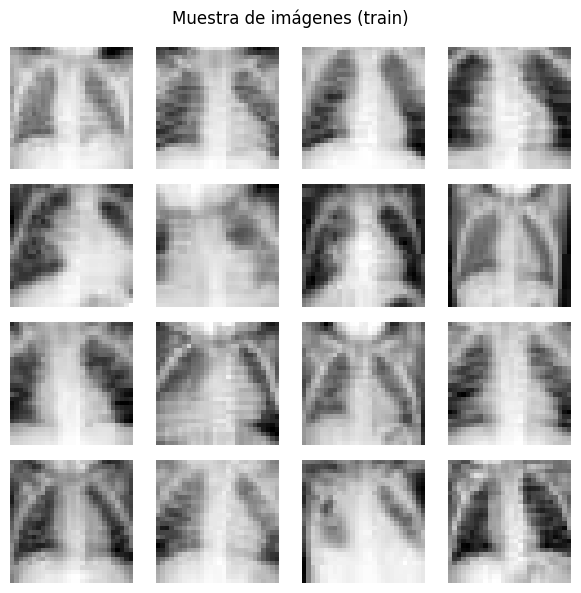

In [3]:
# Transformación básica: solo pasar a tensor (escala 0–1)
tf = transforms.Compose([transforms.ToTensor()])

# Descargo y preparo los splits de MedMNIST
train_set = PneumoniaMNIST(split='train', transform=tf, download=True)
val_set   = PneumoniaMNIST(split='val',   transform=tf, download=True)
test_set  = PneumoniaMNIST(split='test',  transform=tf, download=True)

def to_tensors(ds):
    """
    Pasar el dataset de MedMNIST a tensores completos en memoria:
      xs: (N,1,28,28)
      ys: (N,)
    """
    xs = torch.stack([
        (ds[i][0] if isinstance(ds[i][0], torch.Tensor) else torch.as_tensor(ds[i][0]))
        .to('cpu').float()
        for i in range(len(ds))
    ], dim=0)  # (N,1,28,28)
    ys = torch.tensor([
        (ds[i][1].item() if hasattr(ds[i][1], "item") else np.asarray(ds[i][1]).item())
        for i in range(len(ds))
    ], dtype=torch.long, device='cpu')     # (N,)
    return xs, ys

# Tensores completos de cada split
X_tr, y_tr = to_tensors(train_set)
X_va, y_va = to_tensors(val_set)
X_te, y_te = to_tensors(test_set)

# El generator del DataLoader debe ser de CPU para que no dé problemas con multiprocessing
g_cpu = torch.Generator(device='cpu')
g_cpu.manual_seed(SEED)

num_w = 4  # número de workers para cargar datos en paralelo
train_loader = DataLoader(
    TensorDataset(X_tr, y_tr),
    batch_size=BATCH_SIZE,
    shuffle=True,
    generator=g_cpu,                 # controla el shuffle de forma reproducible
    num_workers=num_w,
    pin_memory=True,
    persistent_workers=(num_w > 0)
)
val_loader   = DataLoader(
    TensorDataset(X_va, y_va),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_w,
    pin_memory=True,
    persistent_workers=(num_w > 0)
)
test_loader  = DataLoader(
    TensorDataset(X_te, y_te),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_w,
    pin_memory=True,
    persistent_workers=(num_w > 0)
)

print(f"Train: {len(train_loader.dataset)} | Val: {len(val_loader.dataset)} | Test: {len(test_loader.dataset)}")
print("Ejemplo shape batch:", next(iter(train_loader))[0].shape)

# Visualizo algunas imágenes de ejemplo del conjunto de entrenamiento
imgs, ys = next(iter(train_loader))
fig, axs = plt.subplots(4,4, figsize=(6,6))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(imgs[i,0].numpy(), cmap='gray'); ax.axis('off')
plt.suptitle("Muestra de imágenes (train)"); plt.tight_layout(); plt.show()

## **3) Dispositivo cuántico y QNode batched**

Aquí defino el simulador cuántico y el circuito que voy a usar como “filtro quanvolucional” sencillo que ya llevo trabajando desde hace tiempo. Recordemos que la idea de este notebook es agregar la CNN, por eso mismo no me estoy enfocando en las demás cosas. El próximo notebook me enfocare en mejorar el VQA para tener alguno más complejo y con una contrucción con mejor sentido. 

Primero configuro el dispositivo de PennyLane, basado en default.qubit.torch, para que pueda integrarse con PyTorch y vivir en la GPU cuando esté disponible. Después defino el qnode quanv_circuit_batched, que recibe muchos parches al mismo tiempo como x_angles_b y aplica el mismo ansatz a todos ellos.

Estructura del circuito:
| Etapa            | Descripción                                                       |
| ---------------- | ----------------------------------------------------------------- |
| `RY` de entrada  | Codifico cada pixel del parche como una rotación en Y en su qubit |
| Capas del ansatz | Para cada capa: `RY` y `RZ` entrenables por qubit                 |
| Acoplamiento     | Anillo de CNOTs para correlacionar los 4 qubits del parche        |
| Medición         | Valor esperado de `PauliZ` en cada qubit (4 salidas por parche)   |

In [4]:
# Indico a PennyLane si debe trabajar con tensores en GPU o CPU, pero siempre usando Torch
pl_torch_device = "cuda" if DEVICE.type == "cuda" else "cpu"

# Dispositivo cuántico: simulador de qubits compatible con PyTorch
dev = qml.device(
    "default.qubit.torch",
    wires=QUBITS,
    shots=SHOTS,
    torch_device=pl_torch_device
)

@qml.qnode(dev, interface="torch", diff_method=DIFF_METHOD)
def quanv_circuit_batched(x_angles_b, weights):

    # Codificación de datos: cada columna controla el ángulo RY en un qubit
    for w in range(QUBITS):
        qml.RY(x_angles_b[:, w], wires=w)

    # Ansatz con capas de rotaciones y CNOTs en anillo
    for l in range(LAYERS):
        for w in range(QUBITS):
            qml.RY(weights[l, w, 0], wires=w)
            qml.RZ(weights[l, w, 1], wires=w)
        qml.CNOT([0,1]); qml.CNOT([1,2]); qml.CNOT([2,3]); qml.CNOT([3,0])

    # Devuelvo las expectativas de PauliZ en los cuatro qubits
    return (qml.expval(qml.PauliZ(0)),
            qml.expval(qml.PauliZ(1)),
            qml.expval(qml.PauliZ(2)),
            qml.expval(qml.PauliZ(3)))

## **4) Capa Quanv2x2_28 (batched, rearmado a 4×28×28)**

En esta sección implemento la capa quanvolucional como un módulo de PyTorch (nn.Module). Esta capa recibe imágenes clásicas y devuelve mapas de características cuánticos.

El flujo es:

1) Tomo imágenes de forma (B,1,28,28) y las paso por un unfold estilo convolución con kernel 2×2 y stride 1. Antes hago un padding para que el número de posiciones siga siendo 28×28.
2) Aplano cada parche de 2×2 en un vector de longitud 4 y lo escalo por pi para obtener los ángulos angles.
3) Llamo al circuito cuántico para todos los parches. Si chunk no es None, lo hago en bloques para no saturar memoria.
4) Rearmo la salida para tener un tensor de forma (B,4,28,28), donde 4 es el número de canales (uno por qubit).

Tabla para llevar la dimensión:
| Tensor       | Forma         | Descripción                               |
| ------------ | ------------- | ----------------------------------------- |
| `x`          | `(B,1,28,28)` | Imagen original                           |
| `patches`    | `(B*784, 4)`  | Todos los parches 2x2 aplanados           |
| `angles`     | `(B*784, 4)`  | Ángulos de RY/RZ para el circuito         |
| `outs`       | `(B*784, 4)`  | Expectativas de PauliZ por parche y qubit |
| salida final | `(B,4,28,28)` | Mapas cuánticos rearmados por posición    |

In [5]:
class Quanv2x2_28(nn.Module):
    def __init__(self, chunk_patches: int | None = 16384):
        super().__init__()
        # Parámetros cuánticos del ansatz: (LAYERS, QUBITS, 2) para RY y RZ
        self.weights = nn.Parameter(
            0.1 * torch.randn(LAYERS, QUBITS, 2, device=DEVICE)
        )
        self._dbg_printed = False
        self.chunk = chunk_patches  # número de parches por chunk (None = todo de golpe)

    def forward(self, x):
        B, C, H, W = x.shape
        assert C == 1 and H == 28 and W == 28, "Esperaba (B,1,28,28)."

        # SAME-28: pad en borde derecho e inferior y stride=1, se generan 28*28 parches por imagen
        xpad = F.pad(x, (0,1,0,1), mode="constant", value=0.0)      # (B,1,29,29)
        patches = F.unfold(xpad, kernel_size=2, stride=1)           # (B,4, 28*28)
        patches = patches.transpose(1, 2).reshape(-1, 4)            # (B*784, 4)

        # Escalo a ángulos (en radianes) para la codificación de datos
        angles  = torch.pi * patches                                # (Npatches, 4)

        # QNode vectorizado (en chunks si hace falta VRAM)
        if self.chunk is None:
            m0, m1, m2, m3 = quanv_circuit_batched(angles, self.weights)
            outs = torch.stack([m0, m1, m2, m3], dim=1)             # (Npatches, 4)
        else:
            outs_list = []
            N = angles.shape[0]
            for s in range(0, N, self.chunk):
                a = angles[s:s+self.chunk]
                m0, m1, m2, m3 = quanv_circuit_batched(a, self.weights)
                outs_list.append(torch.stack([m0, m1, m2, m3], dim=1))
            outs = torch.cat(outs_list, dim=0)                      # (Npatches, 4)

        # Reconstrucción espacial: reorganizo parches en un mapa 4x28x28
        outs = outs.view(B, 28*28, 4).permute(0, 2, 1).contiguous().view(B, 4, 28, 28)
        outs = outs.to(x.dtype)  # float32

        # Mensaje de depuración solo la primera vez
        if not self._dbg_printed:
            print(f"[Quanv] out: {outs.shape}, dtype={outs.dtype}, chunk={self.chunk}")
            self._dbg_printed = True
        return outs

## **5) Cabeza convolucional (CNN sobre salida cuántica)**

Aquí defino la parte clásica que toma como entrada los 4 canales cuánticos por imagen y produce un logit final. La estructura es bastante estándar:

- Dos bloques convolución + ReLU + MaxPool que reducen resolución de 28x28 a 7x7.

- Aplanado del tensor y paso por dos capas lineales con una capa de dropout intermedia.

Resumen de arquitectura de la cabeza:
| Bloque | Forma entrada  | Operación principal       | Forma salida   |
| ------ | -------------- | ------------------------- | -------------- |
| Conv1  | `(B,4,28,28)`  | `Conv2d(4,16)` + MaxPool  | `(B,16,14,14)` |
| Conv2  | `(B,16,14,14)` | `Conv2d(16,32)` + MaxPool | `(B,32,7,7)`   |
| FC1    | `(B,32*7*7)`   | `Linear` + ReLU + Dropout | `(B,64)`       |
| FC2    | `(B,64)`       | `Linear`                  | `(B,1)`        |

In [6]:
class ConvHead(nn.Module):
    def __init__(self, in_channels=4, dropout_p=DROPOUT_P, out_dim=OUT_DIM):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),           # 28x28 -> 14x14

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),           # 14x14 -> 7x7
        )
        self.dropout = nn.Dropout(p=dropout_p)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, out_dim)

    def forward(self, z):
        # Bloque convolucional: extracción de características clásicas
        z = self.cnn(z)                # (B,32,7,7)

        # Aplanado y paso por las capas totalmente conectadas
        B = z.shape[0]
        z = z.view(B, -1)              # (B,32*7*7)
        z = F.relu(self.fc1(z))
        z = self.dropout(z)
        z = self.fc2(z)                # (B,1)
        return z

## **6) Modelo completo: QCNN = Quanv2x2_28 + ConvHead**

En esta sección combino, o ensamblo, todo lo anterior en un solo modelo PyTorch. El flujo es:

1) Quanv2x2_28 toma la imagen clásica y produce cuatro canales cuánticos.

2) ConvHead toma esos canales y produce un logit binario.

Esta clase es la que luego se entrena y evalúa. La función build_qcnn() es solo un pequeño helper para crear el modelo directamente en el dispositivo adecuado.

In [7]:
class QCNNModel(nn.Module):
    def __init__(self):

        super().__init__()
        self.quanv = Quanv2x2_28(chunk_patches=16384)
        self.head  = ConvHead(in_channels=4, dropout_p=DROPOUT_P, out_dim=OUT_DIM)

    def forward(self, x):
        # Paso 1: mapear la imagen clásica a cuatro canales cuánticos
        zq = self.quanv(x)  # (B,4,28,28)

        # Paso 2: aplicar la cabeza clásica para producir el logit final
        out = self.head(zq) # (B,1)
        return out

def build_qcnn():
    # Construyo el modelo QCNN y lo envío al dispositivo (CPU o GPU)
    model = QCNNModel().to(DEVICE)
    return model

model = build_qcnn()
print(model)

QCNNModel(
  (quanv): Quanv2x2_28()
  (head): ConvHead(
    (cnn): Sequential(
      (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (dropout): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=1568, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=1, bias=True)
  )
)


## **7) Función de visualización por época**

Esta función la uso solo para inspeccionar qué está “viendo” la parte cuántica del modelo a lo largo del entrenamiento. Para cada época selecciono el primer ejemplo de un batch y ploteo la imagen original y la misma imagen después de la capa quanvolucional, promediando los cuatro canales y con cada uno de los cuatro canales cuánticos por separado.

Esto me ayuda a visualizar si el modelo está aprendiendo patrones razonables en la representación cuántica, además de prepararme para el siguiente notebook que justo me centrare en mejorar el VQA. 

In [8]:
def visualize_quanv_epoch(model, dloader, epoch, device=DEVICE):

    model.eval()
    with torch.no_grad():
        # Tomo un batch cualquiera del dataloader
        xb, yb = next(iter(dloader))        # batch aleatorio
        xb = xb.to(device, non_blocking=True)

        # Paso solo por la capa quanvolucional
        zq = model.quanv(xb)                # (B,4,28,28)

        # Selecciono el primer ejemplo del batch
        x0 = xb[0, 0].detach().cpu()        # (28,28)
        z0 = zq[0].detach().cpu()           # (4,28,28)
        z0_mean = z0.mean(dim=0)            # (28,28)

    # Figura 1: imagen original vs imagen "cuántica promediada"
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))
    fig.suptitle(f"Época {epoch} - Ejemplo imagen 0", fontsize=12)

    axs[0].imshow(x0, cmap="gray")
    axs[0].set_title("Imagen original")
    axs[0].axis("off")

    axs[1].imshow(z0_mean, cmap="gray")
    axs[1].set_title("Después de Quanv (mean canales)")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

    # Figura 2: los cuatro canales cuánticos por separado
    fig2, axs2 = plt.subplots(1, 4, figsize=(10, 3))
    fig2.suptitle(f"Época {epoch} - Canales cuánticos (imagen 0)", fontsize=12)
    for c in range(4):
        axs2[c].imshow(z0[c], cmap="gray")
        axs2[c].set_title(f"Canal {c}")
        axs2[c].axis("off")
    plt.tight_layout()
    plt.show()

## **8) Entrenamiento + validación (umbral óptimo)**

En esta sección está todo el loop de entrenamiento y validación del modelo híbrido. Hago varias cosas, pero son como los notebooks anteriores:

8.1. Calculo un pos_weight para compensar el desbalance de clases directamente en BCEWithLogitsLoss.

8.2 Defino el optimizador Adam para todos los parámetros (clásicos y cuánticos).

8.3 Escribo una función _best_threshold que, dado un conjunto de probabilidades, encuentra el umbral que maximiza el índice de Youden (tpr - fpr) en la curva ROC.

8.4. Defino train_epoch_q, que recorre el DataLoader de train, calcula la pérdida, hace backprop y acumula la pérdida media y la accuracy con umbral 0.5.

8.5. Defino eval_epoch_q, que recorre el DataLoader de validación sin actualizar el modelo, acumula logits y calcula: pérdida media, AUC ROC, mejor umbral en validación, accuracy y F1 tanto al mejor umbral como a 0.5.

8.6. En el loop de épocas llamo a las funciones de train y eval, guardo las métricas en history y guardo una copia de los pesos cuánticos en history_theta para luego graficarlos. Despues mantengo el mejor estado (según val_loss) y el umbral correspondiente y llamo a visualize_quanv_epoch para ver cómo evoluciona la representación.

[Info] pos_weight (train): 0.347  (pos=3494, neg=1214)
[Quanv] out: torch.Size([64, 4, 28, 28]), dtype=torch.float32, chunk=16384
Época 01 (dt=22.0s) | Train: loss=0.3548, acc@0.5=26.0% | Val: loss=0.3513, acc@thr*=84.5%, AUC=0.936, F1=0.887, thr*=0.478 | Val@0.5: acc=25.8%, F1=0.000


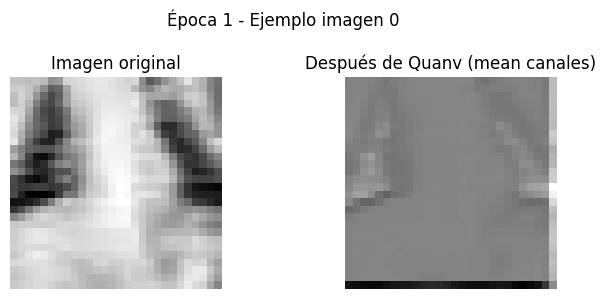

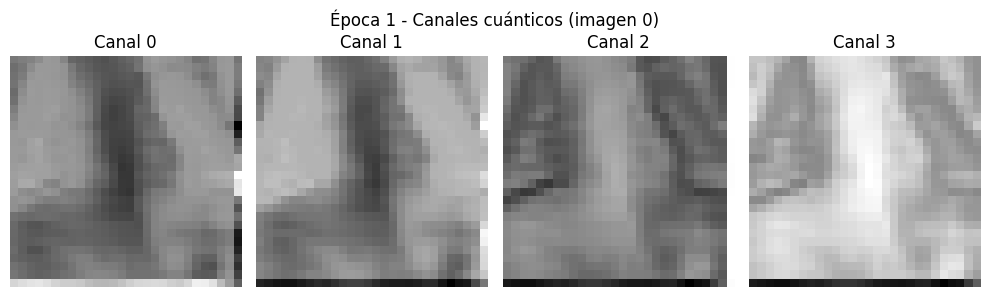

Época 02 (dt=17.2s) | Train: loss=0.3464, acc@0.5=31.4% | Val: loss=0.3395, acc@thr*=84.4%, AUC=0.930, F1=0.886, thr*=0.483 | Val@0.5: acc=59.4%, F1=0.623


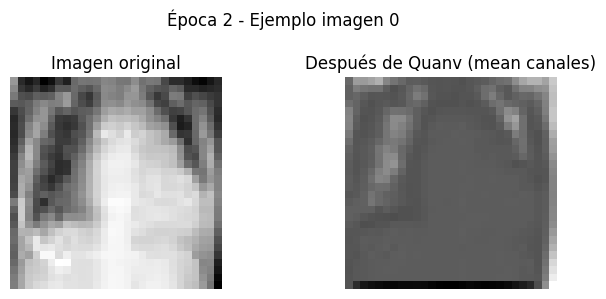

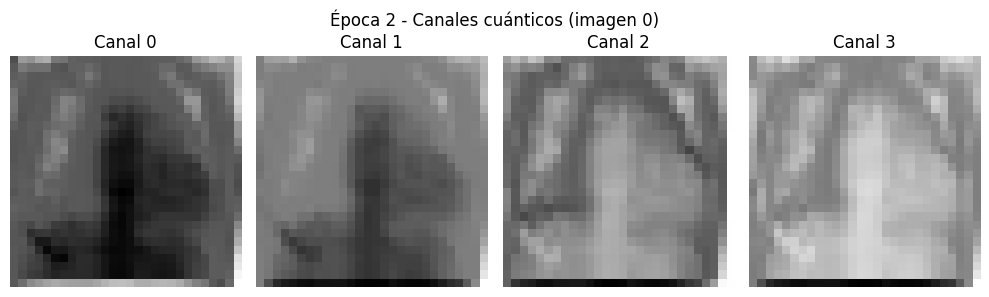

Época 03 (dt=17.1s) | Train: loss=0.3279, acc@0.5=72.9% | Val: loss=0.3145, acc@thr*=88.7%, AUC=0.933, F1=0.923, thr*=0.461 | Val@0.5: acc=74.0%, F1=0.791


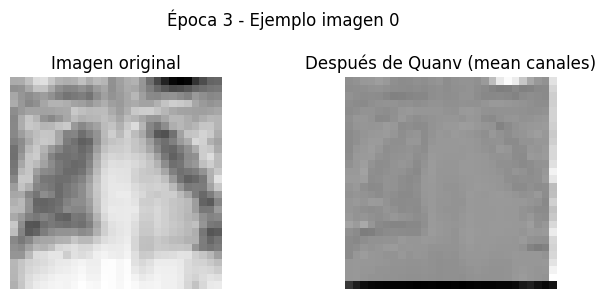

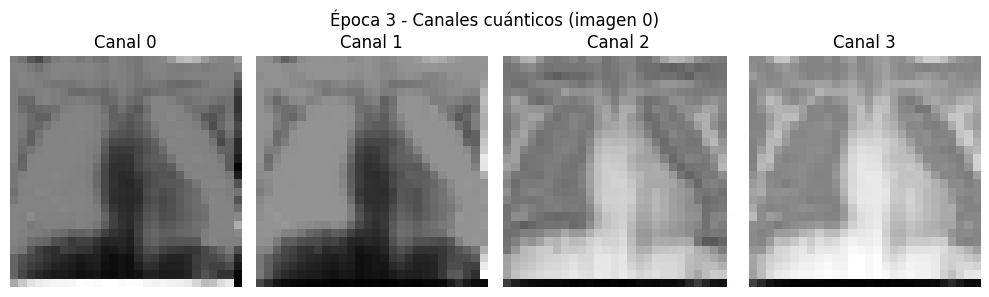

Época 04 (dt=16.1s) | Train: loss=0.2948, acc@0.5=81.4% | Val: loss=0.2752, acc@thr*=88.5%, AUC=0.940, F1=0.921, thr*=0.449 | Val@0.5: acc=78.8%, F1=0.837


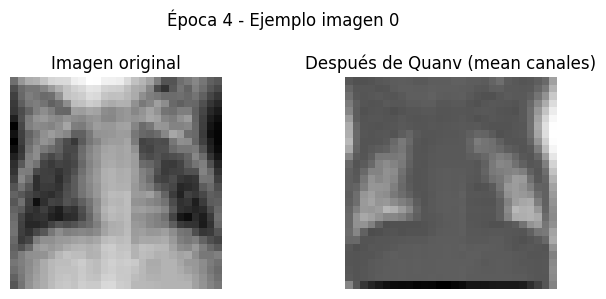

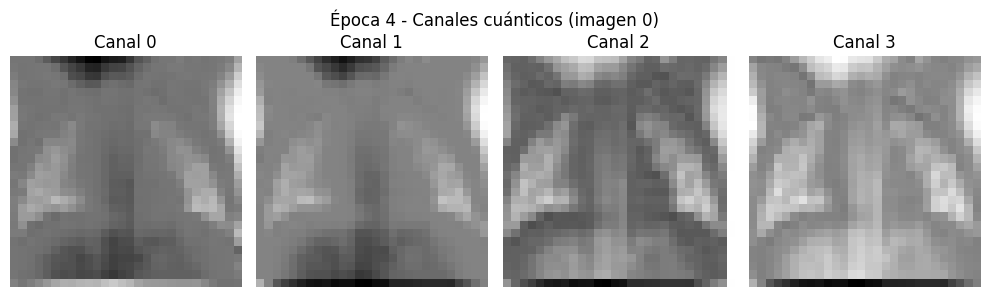

Época 05 (dt=16.4s) | Train: loss=0.2497, acc@0.5=85.1% | Val: loss=0.2289, acc@thr*=91.4%, AUC=0.949, F1=0.943, thr*=0.416 | Val@0.5: acc=83.8%, F1=0.880


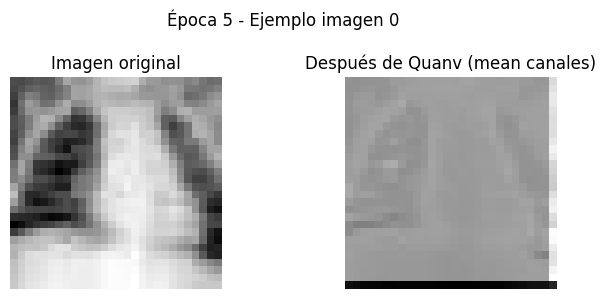

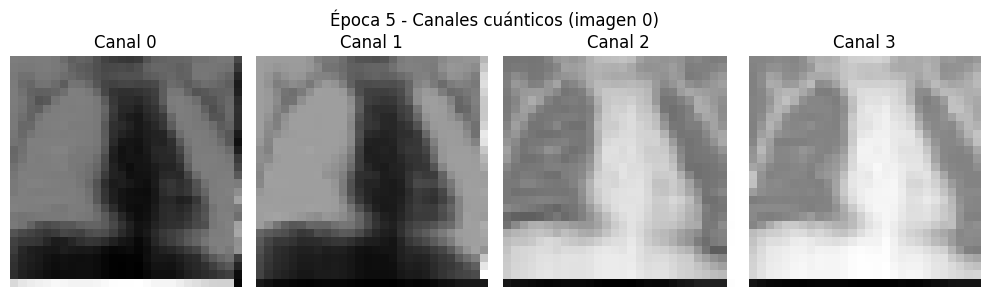

Época 06 (dt=16.2s) | Train: loss=0.2047, acc@0.5=88.5% | Val: loss=0.1891, acc@thr*=92.7%, AUC=0.957, F1=0.952, thr*=0.380 | Val@0.5: acc=85.7%, F1=0.897


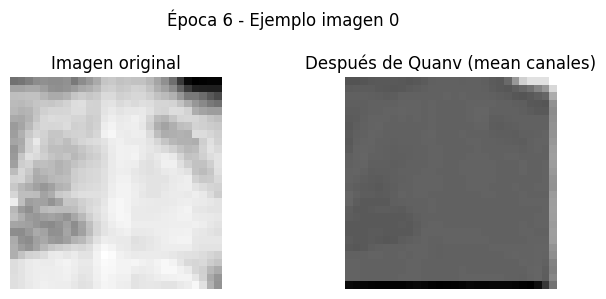

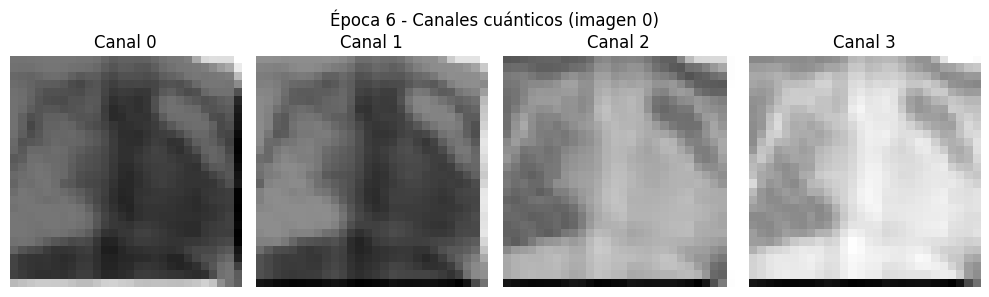

Época 07 (dt=17.4s) | Train: loss=0.1685, acc@0.5=90.4% | Val: loss=0.1613, acc@thr*=91.6%, AUC=0.961, F1=0.943, thr*=0.437 | Val@0.5: acc=88.2%, F1=0.916


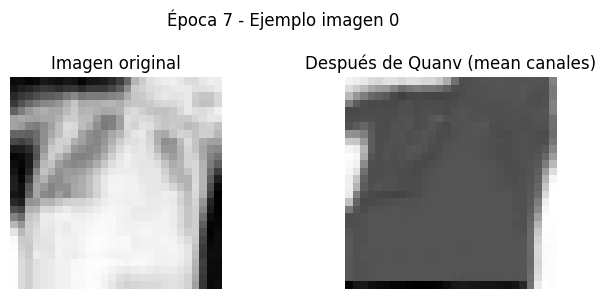

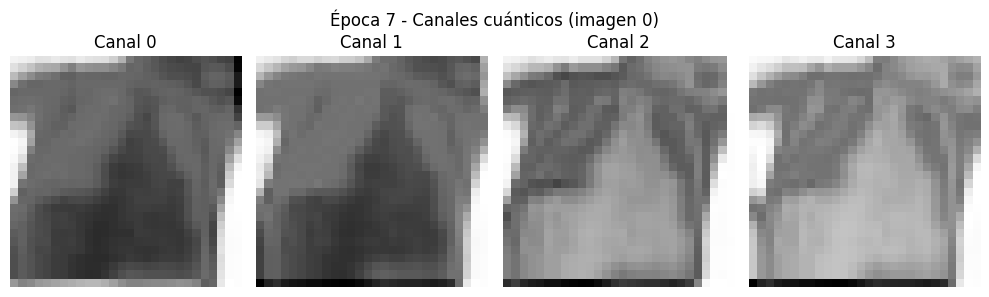

Época 08 (dt=17.1s) | Train: loss=0.1444, acc@0.5=91.1% | Val: loss=0.1432, acc@thr*=92.2%, AUC=0.964, F1=0.947, thr*=0.417 | Val@0.5: acc=88.2%, F1=0.916


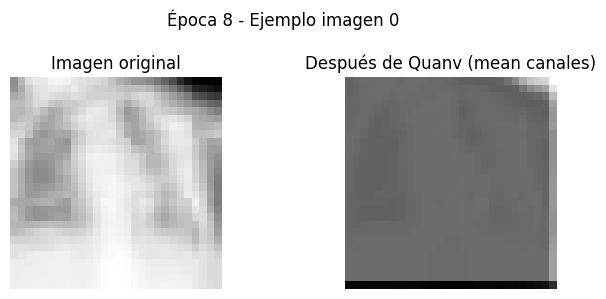

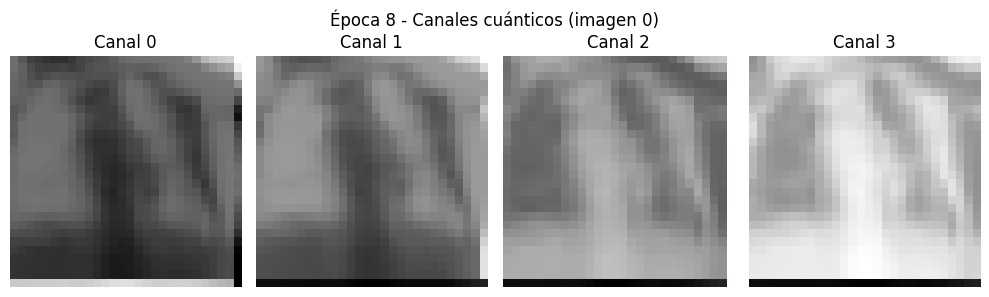

Época 09 (dt=17.4s) | Train: loss=0.1287, acc@0.5=91.7% | Val: loss=0.1312, acc@thr*=93.5%, AUC=0.966, F1=0.956, thr*=0.380 | Val@0.5: acc=89.1%, F1=0.924


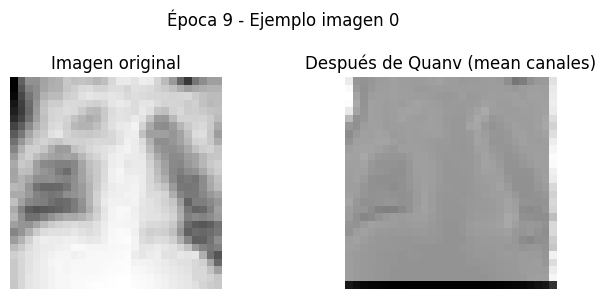

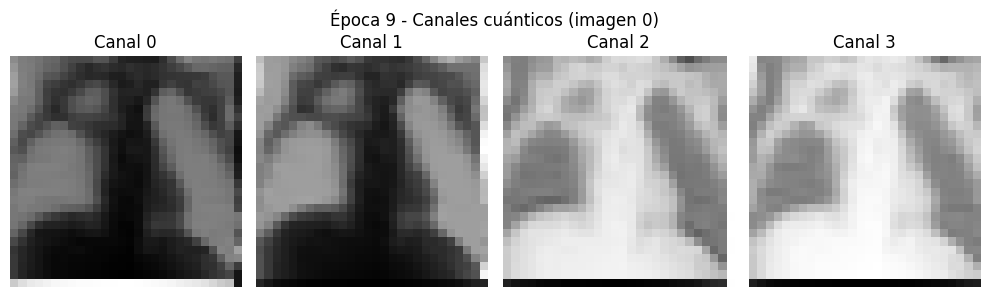

Época 10 (dt=16.3s) | Train: loss=0.1184, acc@0.5=92.1% | Val: loss=0.1254, acc@thr*=93.3%, AUC=0.967, F1=0.955, thr*=0.489 | Val@0.5: acc=92.6%, F1=0.949


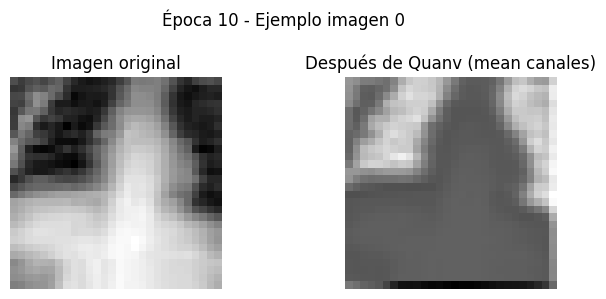

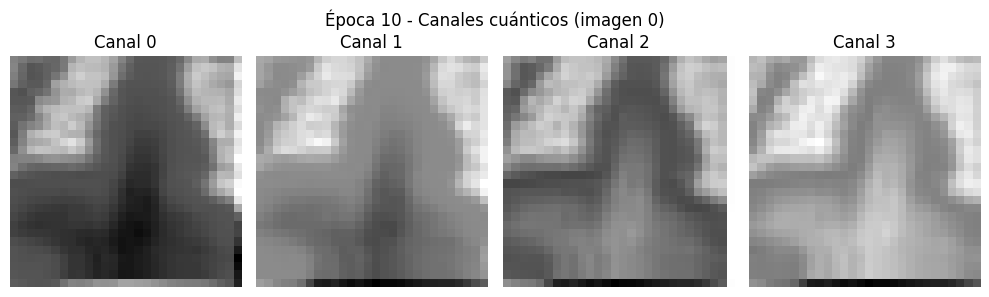

Época 11 (dt=17.5s) | Train: loss=0.1122, acc@0.5=92.4% | Val: loss=0.1182, acc@thr*=93.7%, AUC=0.970, F1=0.957, thr*=0.350 | Val@0.5: acc=90.3%, F1=0.932


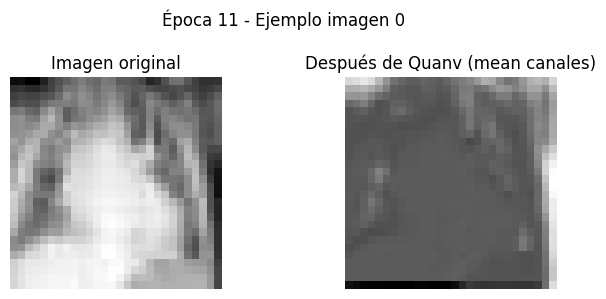

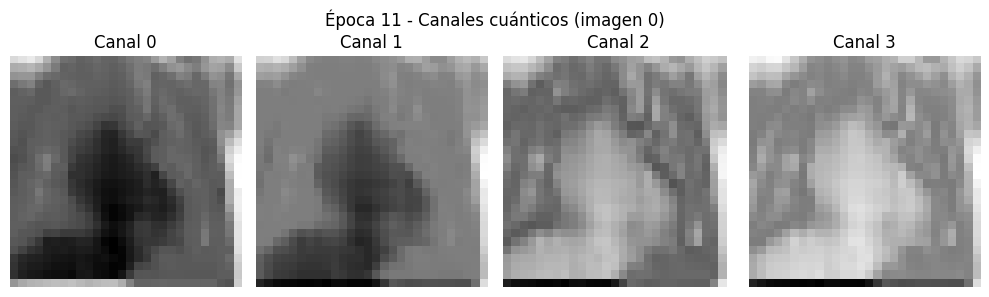

Época 12 (dt=16.7s) | Train: loss=0.1066, acc@0.5=92.6% | Val: loss=0.1120, acc@thr*=94.7%, AUC=0.972, F1=0.964, thr*=0.293 | Val@0.5: acc=90.3%, F1=0.932


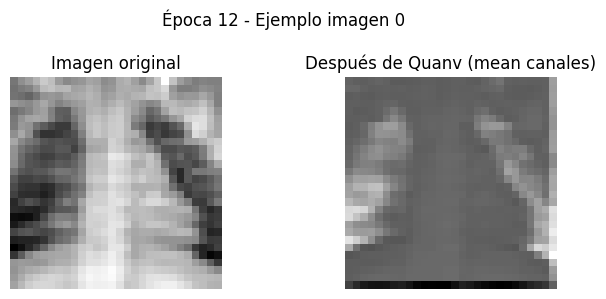

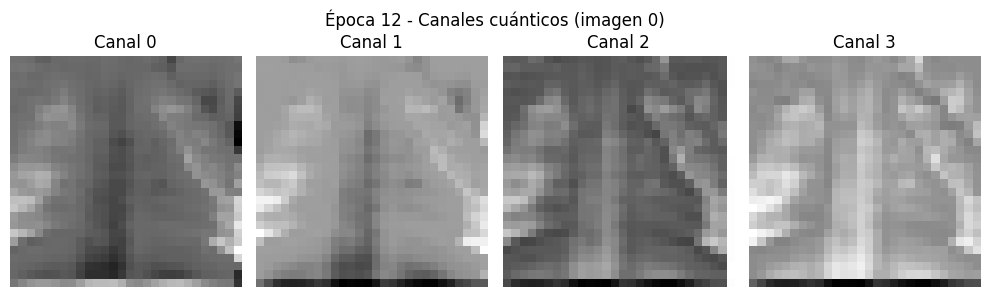

Época 13 (dt=16.4s) | Train: loss=0.1011, acc@0.5=92.9% | Val: loss=0.1077, acc@thr*=94.7%, AUC=0.973, F1=0.964, thr*=0.303 | Val@0.5: acc=90.6%, F1=0.935


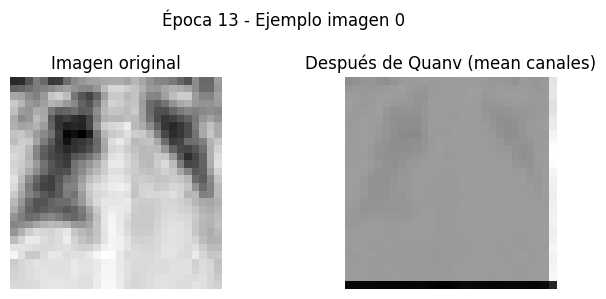

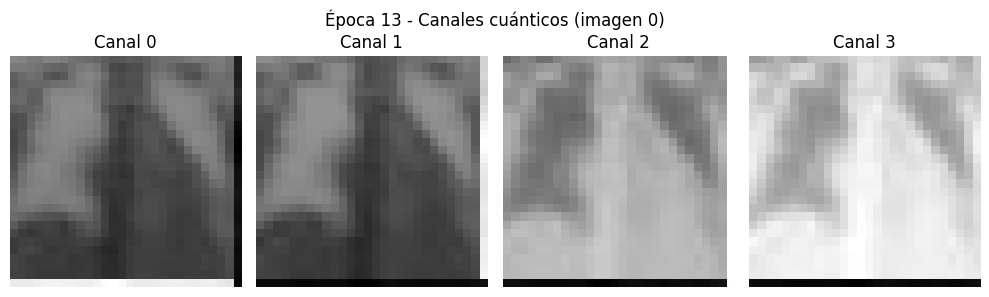

Época 14 (dt=16.2s) | Train: loss=0.0977, acc@0.5=92.9% | Val: loss=0.1041, acc@thr*=95.2%, AUC=0.975, F1=0.968, thr*=0.315 | Val@0.5: acc=91.6%, F1=0.942


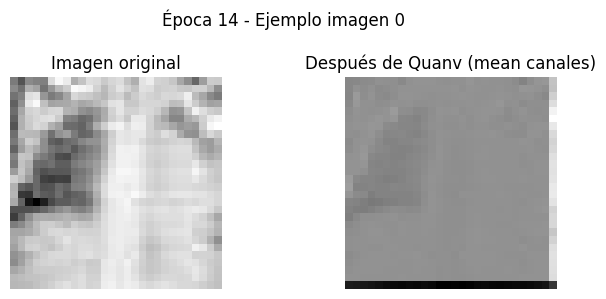

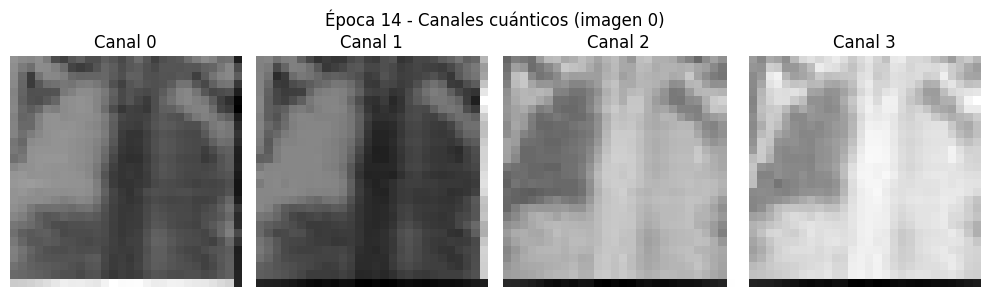

Época 15 (dt=16.7s) | Train: loss=0.0956, acc@0.5=93.2% | Val: loss=0.1015, acc@thr*=95.0%, AUC=0.976, F1=0.967, thr*=0.355 | Val@0.5: acc=92.6%, F1=0.949


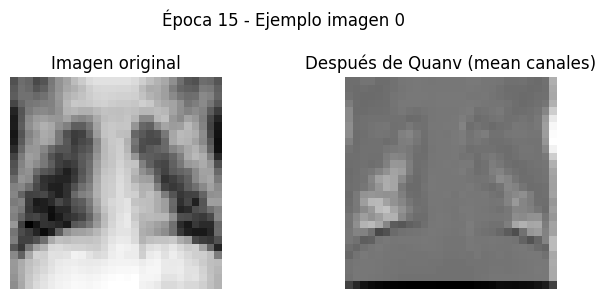

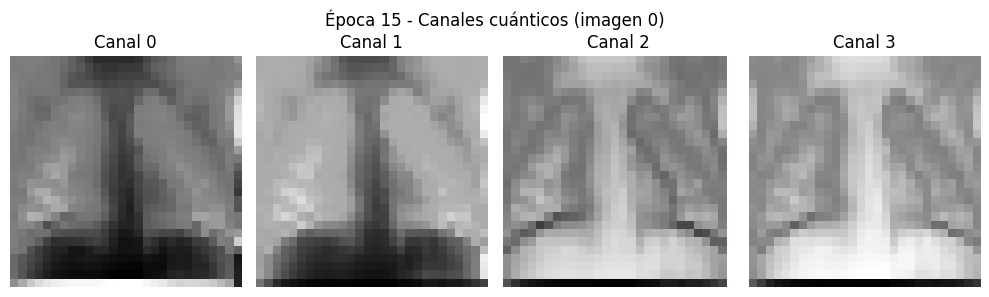

Época 16 (dt=16.2s) | Train: loss=0.0926, acc@0.5=93.3% | Val: loss=0.0983, acc@thr*=92.0%, AUC=0.978, F1=0.944, thr*=0.534 | Val@0.5: acc=91.8%, F1=0.943


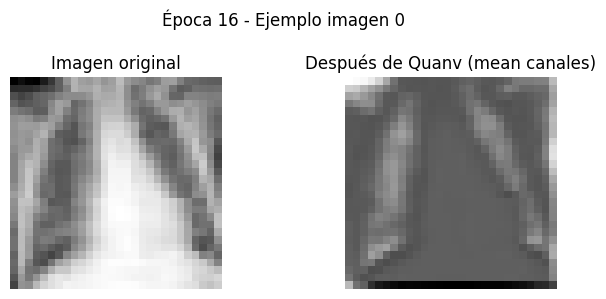

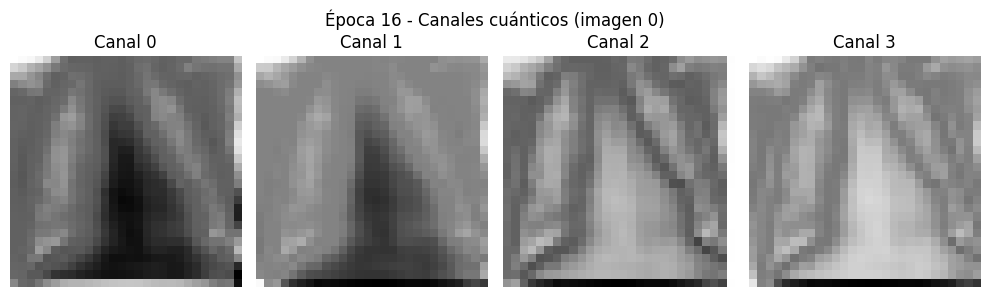

Época 17 (dt=16.2s) | Train: loss=0.0906, acc@0.5=93.6% | Val: loss=0.0957, acc@thr*=94.8%, AUC=0.979, F1=0.965, thr*=0.344 | Val@0.5: acc=91.8%, F1=0.943


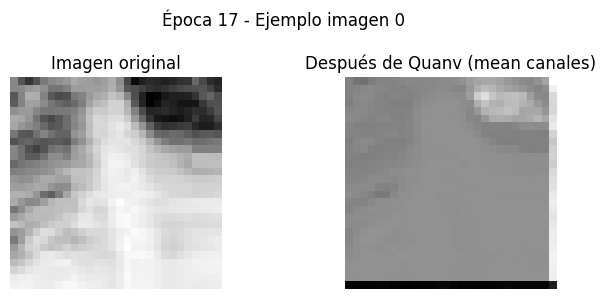

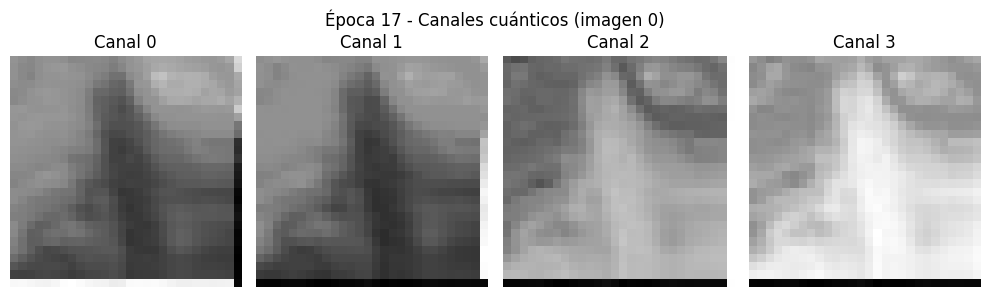

Época 18 (dt=16.3s) | Train: loss=0.0895, acc@0.5=93.6% | Val: loss=0.0954, acc@thr*=92.4%, AUC=0.980, F1=0.947, thr*=0.493 | Val@0.5: acc=92.2%, F1=0.945


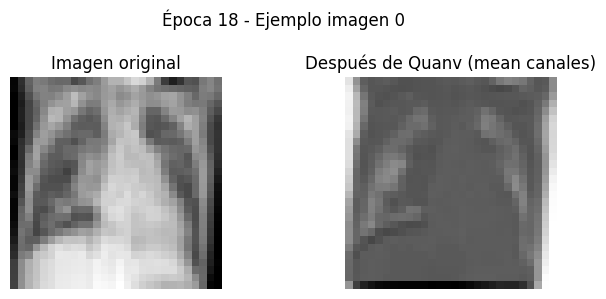

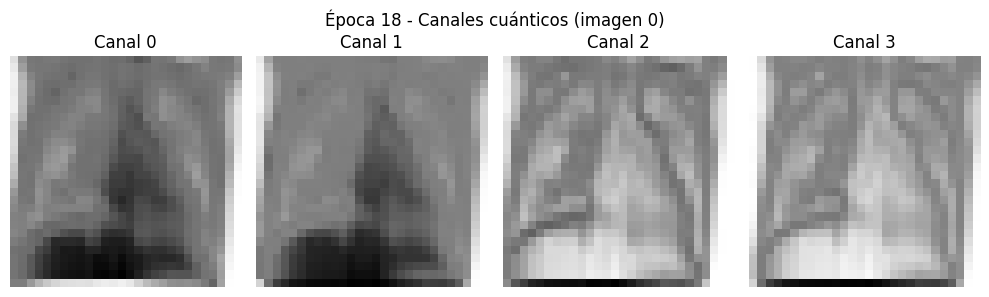

Época 19 (dt=17.5s) | Train: loss=0.0862, acc@0.5=93.9% | Val: loss=0.0918, acc@thr*=95.0%, AUC=0.980, F1=0.967, thr*=0.362 | Val@0.5: acc=92.9%, F1=0.952


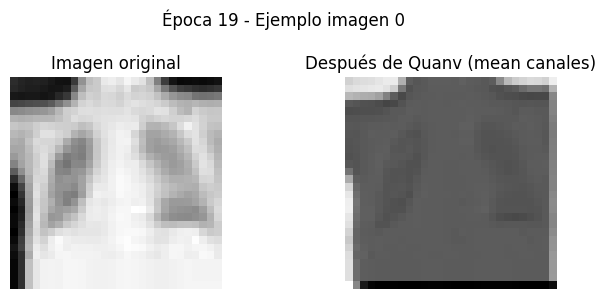

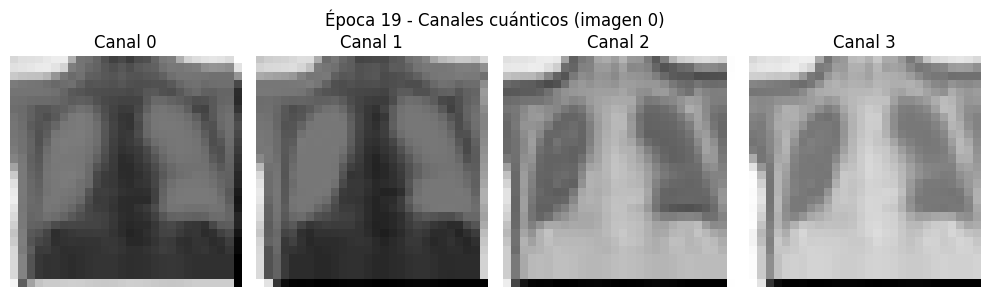

Época 20 (dt=17.4s) | Train: loss=0.0857, acc@0.5=93.8% | Val: loss=0.0917, acc@thr*=92.7%, AUC=0.982, F1=0.949, thr*=0.483 | Val@0.5: acc=92.4%, F1=0.947


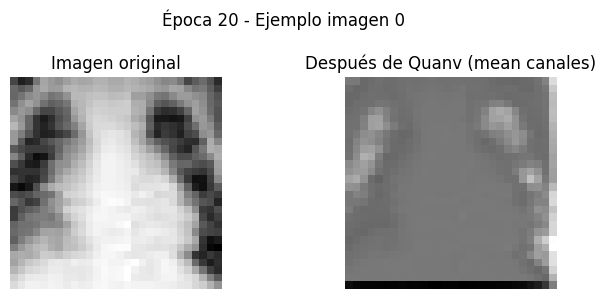

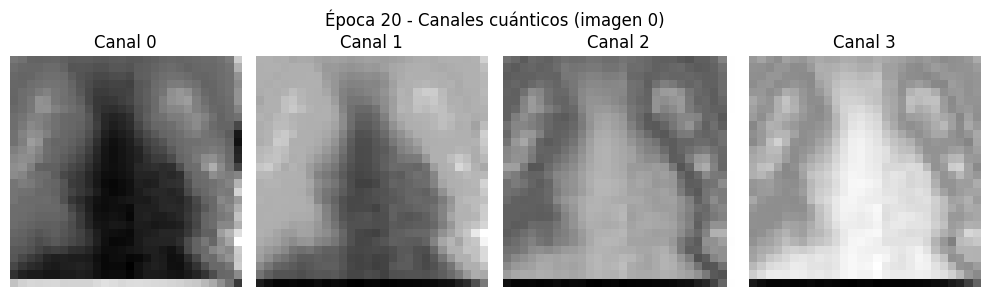

[Info] Mejor estado QCNN restaurado (val_loss=0.0917, thr*=0.483)


In [9]:
# Cálculo del peso para la clase positiva según el desbalance del train
with torch.no_grad():
    n_pos = int((y_tr == CLASS_POS).sum())
    n_neg = int((y_tr == CLASS_NEG).sum())
pos_weight_val = n_neg / max(1, n_pos)
print(f"[Info] pos_weight (train): {pos_weight_val:.3f}  (pos={n_pos}, neg={n_neg})")

# Pérdida binaria con logits + peso para la clase positiva
criterion = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([pos_weight_val], device=DEVICE, dtype=torch.float32)
)

# Optimizador para todos los parámetros del modelo híbrido
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

def _best_threshold(y_true, probs):
    fpr, tpr, thrs = roc_curve(y_true, probs)
    youden = tpr - fpr
    idx = np.argmax(youden)
    return thrs[idx]

def train_epoch_q(dloader):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for xb, yb in dloader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True).float()

        logits = model(xb).view(-1)
        loss   = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        preds = (logits >= 0).long()
        total_correct += (preds == yb.long()).sum().item()
        total_samples += xb.size(0)

    avg_loss = total_loss / total_samples
    acc = total_correct / total_samples
    return avg_loss, acc

@torch.no_grad()
def eval_epoch_q(dloader):
    model.eval()
    all_logits = []
    all_y      = []
    total_loss = 0.0
    total_samples = 0

    for xb, yb in dloader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True).float()

        logits = model(xb).view(-1)
        loss   = criterion(logits, yb)

        total_loss += loss.item() * xb.size(0)
        total_samples += xb.size(0)

        all_logits.append(logits.detach().cpu())
        all_y.append(yb.detach().cpu())

    avg_loss = total_loss / total_samples
    logits   = torch.cat(all_logits, dim=0).numpy()
    y_true   = torch.cat(all_y,      dim=0).numpy()

    # Paso a probabilidades aplicando sigmoide de manera explícita
    probs = 1.0 / (1.0 + np.exp(-logits))

    # AUC ROC (si se puede calcular)
    try:
        auc = roc_auc_score(y_true, probs)
    except:
        auc = float("nan")

    # Umbral óptimo con el criterio de Youden
    thr_star = _best_threshold(y_true, probs)

    # Métricas al umbral óptimo thr*
    y_hat_thr = (probs >= thr_star).astype(int)
    acc_thr   = accuracy_score(y_true, y_hat_thr)
    f1_thr    = f1_score(y_true, y_hat_thr)

    # Métricas al umbral fijo 0.5
    y_hat_05 = (probs >= 0.5).astype(int)
    acc_05   = accuracy_score(y_true, y_hat_05)
    f1_05    = f1_score(y_true, y_hat_05)

    return avg_loss, acc_thr, auc, f1_thr, thr_star, acc_05, f1_05

# Loop de entrenamiento QCNN

# Diccionario para guardar la historia de métricas
history = {
    "tr_loss": [], "tr_acc05": [],
    "va_loss": [], "va_auc":  [],
    "va_acc_thr": [], "va_f1_thr": [], "va_thr": [],
    "va_acc05": [], "va_f105": []
}
history_theta = []  # pesos cuánticos por época

best_val_loss = float('inf')
best_state    = None
best_thr_val  = 0.5

for ep in range(1, EPOCHS + 1):
    t0 = time.time()
    tr_loss, tr_acc = train_epoch_q(train_loader)
    va_loss, va_acc_thr, va_auc, va_f1_thr, thr_star, va_acc05, va_f105 = eval_epoch_q(val_loader)
    dt = time.time() - t0

    # Actualizo el mejor estado según la pérdida de validación
    if va_loss < best_val_loss:
        best_val_loss = va_loss
        best_state    = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        best_thr_val  = thr_star

    # Guardar historia de métricas
    history["tr_loss"].append(tr_loss)
    history["tr_acc05"].append(tr_acc)
    history["va_loss"].append(va_loss)
    history["va_auc"].append(va_auc)
    history["va_acc_thr"].append(va_acc_thr)
    history["va_f1_thr"].append(va_f1_thr)
    history["va_thr"].append(thr_star)
    history["va_acc05"].append(va_acc05)
    history["va_f105"].append(va_f105)

    # Guardo una copia de todos los parámetros cuánticos para analizarlos después
    history_theta.append(model.quanv.weights.detach().cpu().clone())

    print(f"Época {ep:02d} (dt={dt:.1f}s) | "
          f"Train: loss={tr_loss:.4f}, acc@0.5={tr_acc*100:.1f}% | "
          f"Val: loss={va_loss:.4f}, acc@thr*={va_acc_thr*100:.1f}%, "
          f"AUC={va_auc:.3f}, F1={va_f1_thr:.3f}, thr*={thr_star:.3f} "
          f"| Val@0.5: acc={va_acc05*100:.1f}%, F1={va_f105:.3f}")

    # Visualización de la representación cuántica en cada época
    visualize_quanv_epoch(model, train_loader, ep, device=DEVICE)

# Restaurar mejor estado QCNN (el que minimizó la pérdida de validación)
if best_state is not None:
    model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})
    print(f"[Info] Mejor estado QCNN restaurado (val_loss={best_val_loss:.4f}, thr*={best_thr_val:.3f})")

## **9) Gráficas de pérdida y accuracy (Train/Val)**

En esta sección solo me dedico a visualizar cómo se comportó el entrenamiento del modelo híbrido a lo largo de las épocas. Uso el diccionario history que llené en la sección 8 para graficar:

- La pérdida de entrenamiento y validación.

- La accuracy de entrenamiento y validación usando el umbral fijo 0.5.

Estas curvas me sirven para ver si el modelo está sobreajustando o detectar si el aprendizaje se estanca muy pronto o si aún podría beneficiarse de más épocas. Al final tambien para comparar la estabilidad del entrenamiento del QCNN frente al modelo clásico CNN que defino después en la ultima sección.

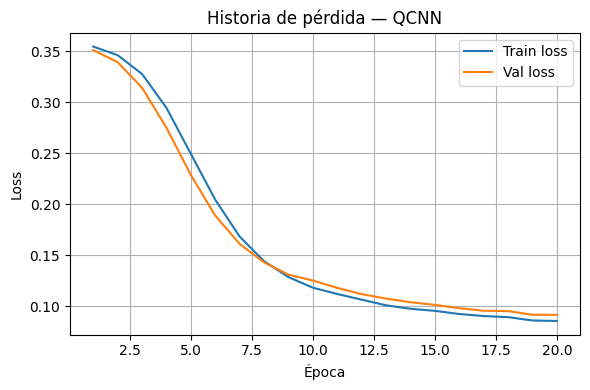

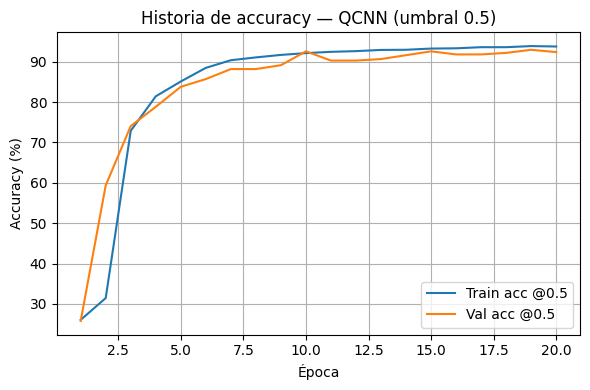

In [10]:
# Rango de épocas para las gráficas
epochs_range = range(1, EPOCHS + 1)

# Curvas de pérdida (train vs val)
plt.figure(figsize=(6,4))
plt.plot(epochs_range, history["tr_loss"], label="Train loss")
plt.plot(epochs_range, history["va_loss"], label="Val loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Historia de pérdida — QCNN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Curvas de accuracy usando umbral fijo 0.5
plt.figure(figsize=(6,4))
plt.plot(epochs_range, [x*100 for x in history["tr_acc05"]], label="Train acc @0.5")
plt.plot(epochs_range, [x*100 for x in history["va_acc05"]], label="Val acc @0.5")
plt.xlabel("Época")
plt.ylabel("Accuracy (%)")
plt.title("Historia de accuracy — QCNN (umbral 0.5)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **10) Test completo**

Aquí ya no toco el conjunto de entrenamiento ni el de validación. Evalúo el modelo híbrido final sobre el conjunto de prueba (test_loader), que el modelo nunca vio durante el entrenamiento para ambos umbrales.

Y para refrescar la memoria:

| Métrica     | Descripción                                           |
| ----------- | ----------------------------------------------------- |
| `loss`      | Pérdida media de entropía cruzada binaria con logits  |
| `acc`       | Proporción de etiquetas bien clasificadas             |
| `precision` | Qué fracción de los positivos predichos son correctos |
| `recall`    | Qué fracción de los positivos reales se recupera      |
| `f1`        | Media armónica entre precision y recall               |
| `auc`       | AUC ROC sobre probabilidades                          |
| `pr_auc`    | Área bajo la curva Precision–Recall                   |

In [11]:
@torch.no_grad()
def eval_test_qcnn(dloader, threshold):
    model.eval()
    all_logits = []
    all_y      = []
    total_loss = 0.0
    total_samples = 0

    for xb, yb in dloader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True).float()

        logits = model(xb).view(-1)
        loss   = criterion(logits, yb)

        total_loss += loss.item() * xb.size(0)
        total_samples += xb.size(0)

        all_logits.append(logits.detach().cpu())
        all_y.append(yb.detach().cpu())

    # Pérdida media en test
    avg_loss = total_loss / total_samples

    # Paso todos los logits acumulados a NumPy para métricas de sklearn
    logits   = torch.cat(all_logits, dim=0).numpy()
    y_true   = torch.cat(all_y,      dim=0).numpy()
    probs    = 1.0 / (1.0 + np.exp(-logits))

    # Predicciones binarias al umbral especificado
    y_hat = (probs >= threshold).astype(int)

    # Métricas básicas
    acc  = accuracy_score(y_true, y_hat)
    prec, rec, f1_, _ = precision_recall_fscore_support(
        y_true, y_hat,
        average="binary",
        pos_label=CLASS_POS,
        zero_division=0
    )

    # AUC ROC, si se puede calcular
    try:
        auc = roc_auc_score(y_true, probs)
    except:
        auc = float("nan")

    # PR-AUC (área bajo la curva Precision–Recall)
    try:
        pr_auc = average_precision_score(y_true, probs)
    except:
        pr_auc = float("nan")

    # Matriz de confusión y reporte detallado
    cm = confusion_matrix(y_true, y_hat)
    report = classification_report(y_true, y_hat, digits=3)

    return {
        "loss": avg_loss,
        "acc": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1_,        # F1 guardado como 'f1'
        "auc": auc,
        "pr_auc": pr_auc,
        "cm": cm,
        "report": report,
        "threshold": threshold,
    }

def print_test_qcnn(tag, res):
    print(f"\n[{tag}] thr={res['threshold']:.3f}")
    print(f"loss={res['loss']:.4f} | acc={res['acc']*100:.1f}% "
          f"| precision={res['precision']:.3f} | recall={res['recall']:.3f} | F1={res['f1']:.3f}")
    print(f"AUC={res['auc']:.3f} | PR-AUC={res['pr_auc']:.3f}")
    print("Matriz de confusión:\n", res["cm"])
    print("Reporte por clase:\n", res["report"])

# Evaluación con umbral fijo 0.5 y con el umbral óptimo aprendido en validación
res_qcnn_05 = eval_test_qcnn(test_loader, 0.5)
res_qcnn_ts = eval_test_qcnn(test_loader, best_thr_val)

print_test_qcnn("QCNN @0.5", res_qcnn_05)
print_test_qcnn("QCNN @thr*", res_qcnn_ts)


[QCNN @0.5] thr=0.500
loss=0.2824 | acc=88.6% | precision=0.894 | recall=0.928 | F1=0.911
AUC=0.923 | PR-AUC=0.912
Matriz de confusión:
 [[191  43]
 [ 28 362]]
Reporte por clase:
               precision    recall  f1-score   support

         0.0      0.872     0.816     0.843       234
         1.0      0.894     0.928     0.911       390

    accuracy                          0.886       624
   macro avg      0.883     0.872     0.877       624
weighted avg      0.886     0.886     0.885       624


[QCNN @thr*] thr=0.483
loss=0.2824 | acc=89.1% | precision=0.895 | recall=0.936 | F1=0.915
AUC=0.923 | PR-AUC=0.912
Matriz de confusión:
 [[191  43]
 [ 25 365]]
Reporte por clase:
               precision    recall  f1-score   support

         0.0      0.884     0.816     0.849       234
         1.0      0.895     0.936     0.915       390

    accuracy                          0.891       624
   macro avg      0.889     0.876     0.882       624
weighted avg      0.891     0.891     

## **11) Evolución de parámetros cuánticos (ansatz)**

En esta nueva sección analizo qué hicieron los parámetros cuánticos del ansatz a lo largo del entrenamiento. Como en cada época guardé una copia de model.quanv.weights dentro de history_theta, ahora apilo todas esas copias en un tensor de forma (EPOCHS, n_params), donde n_params = LAYERS * QUBITS * 2.

Para cada parámetro individual, dibujo una curva valor vs época y organizo las gráficas en una cuadrícula de tamaño LAYERS × (QUBITS*2):

Esto es importante, pues ahora puedo ver como cambiaron cada parámetro individualmente y poder así en futuros notebooks buscar un buen VQA. 

[Info] Parámetros cuánticos totales: 16 (LAYERS*QUBITS*2)


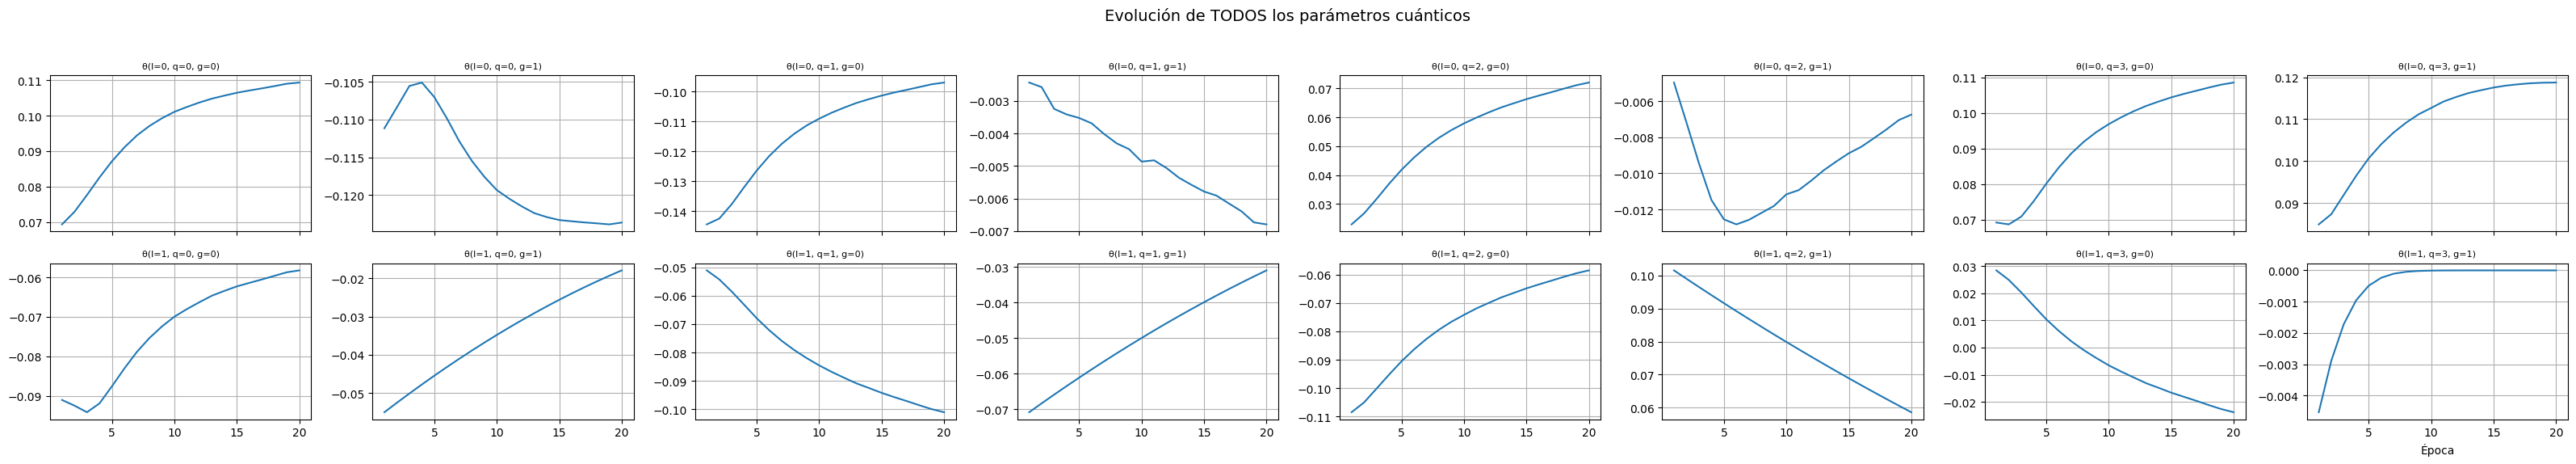

In [12]:
# lista de longitud EPOCHS, cada elemento (LAYERS, QUBITS, 2)
theta_arr = torch.stack(
    [ht.view(-1) for ht in history_theta],
    dim=0
).numpy()  # shape: (EPOCHS, n_params)

# Número total de parámetros cuánticos del ansatz
n_params = theta_arr.shape[1]
print(f"[Info] Parámetros cuánticos totales: {n_params} (LAYERS*QUBITS*2)")

# Creo una rejilla de subplots: una fila por capa y dos columnas por qubit (RY y RZ)
fig, axs = plt.subplots(LAYERS, QUBITS*2, figsize=(4*(QUBITS*2), 3*LAYERS), sharex=True)
fig.suptitle("Evolución de TODOS los parámetros cuánticos", fontsize=14)

idx = 0
for l in range(LAYERS):
    for q in range(QUBITS):
        for g in range(2):
            ax = axs[l, 2*q + g]
            ax.plot(epochs_range, theta_arr[:, idx])
            ax.set_title(f"θ(l={l}, q={q}, g={g})", fontsize=8)
            ax.grid(True)
            idx += 1

plt.xlabel("Época")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## **12) Modelo clásico (CNN pura) + entrenamiento + test**

Finalmente, construyo una CNN totalmente clásica para tener un baseline con el que comparar al QCNN. La idea es:

1) Definir una arquitectura muy parecida a la cabeza clásica del modelo híbrido, pero ahora recibiendo directamente la imagen original (B,1,28,28) en lugar de los 4 canales cuánticos.

2) Entrenar esta CNN con exactamente la misma configuración de pérdida (criterion, con el mismo pos_weight), optimizador Adam, número de épocas, batch size, etc.

Guardarre de igual forma la historia de métricas igual que con el QCNN para poder comparar curvas.
Evaluare en test con los dos umbrales: 0.5 y el umbral óptimo best_thr_cl que se obtiene en validación (misma lógica que antes).

In [13]:
class ClassicalCNN(nn.Module):
    def __init__(self, dropout_p=DROPOUT_P, out_dim=OUT_DIM):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),           # 28x28 -> 14x14

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),           # 14x14 -> 7x7
        )
        self.dropout = nn.Dropout(p=dropout_p)
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, out_dim)

    def forward(self, x):
        # Bloque convolucional sobre la imagen original
        z = self.cnn(x)               # (B,32,7,7)

        # Aplanado y capas fully-connected
        B = z.shape[0]
        z = z.view(B, -1)
        z = F.relu(self.fc1(z))
        z = self.dropout(z)
        z = self.fc2(z)               # (B,1)
        return z

def build_classical():
    # Construyo la CNN clásica y la paso al dispositivo
    model_cl = ClassicalCNN(dropout_p=DROPOUT_P, out_dim=OUT_DIM).to(DEVICE)
    return model_cl

classical_model = build_classical()
print(classical_model)

ClassicalCNN(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=1568, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


In [14]:
optimizer_cl = torch.optim.Adam(classical_model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

def train_epoch_cl(dloader):
    classical_model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for xb, yb in dloader:
        xb = xb.to(DEVICE, non_blocking=True)       # (B,1,28,28)
        yb = yb.to(DEVICE, non_blocking=True).float()

        logits = classical_model(xb).view(-1)
        loss   = criterion(logits, yb)

        optimizer_cl.zero_grad()
        loss.backward()
        optimizer_cl.step()

        total_loss += loss.item() * xb.size(0)
        preds = (logits >= 0).long()
        total_correct += (preds == yb.long()).sum().item()
        total_samples += xb.size(0)

    avg_loss = total_loss / total_samples
    acc = total_correct / total_samples
    return avg_loss, acc

@torch.no_grad()
def eval_epoch_cl(dloader):
    classical_model.eval()
    all_logits = []
    all_y      = []
    total_loss = 0.0
    total_samples = 0

    for xb, yb in dloader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True).float()

        logits = classical_model(xb).view(-1)
        loss   = criterion(logits, yb)

        total_loss += loss.item() * xb.size(0)
        total_samples += xb.size(0)

        all_logits.append(logits.detach().cpu())
        all_y.append(yb.detach().cpu())

    avg_loss = total_loss / total_samples
    logits   = torch.cat(all_logits, dim=0).numpy()
    y_true   = torch.cat(all_y,      dim=0).numpy()

    probs = 1.0 / (1.0 + np.exp(-logits))

    # AUC ROC
    try:
        auc = roc_auc_score(y_true, probs)
    except:
        auc = float("nan")

    # Umbral óptimo con el mismo criterio de Youden
    thr_star = _best_threshold(y_true, probs)

    # Métricas al umbral óptimo
    y_hat_thr = (probs >= thr_star).astype(int)
    acc_thr   = accuracy_score(y_true, y_hat_thr)
    f1_thr    = f1_score(y_true, y_hat_thr)

    # Métricas al umbral fijo 0.5
    y_hat_05 = (probs >= 0.5).astype(int)
    acc_05   = accuracy_score(y_true, y_hat_05)
    f1_05    = f1_score(y_true, y_hat_05)

    return avg_loss, acc_thr, auc, f1_thr, thr_star, acc_05, f1_05

# Historia de métricas para la CNN clásica
history_cl = {
    "tr_loss": [], "tr_acc05": [],
    "va_loss": [], "va_auc":  [],
    "va_acc_thr": [], "va_f1_thr": [], "va_thr": [],
    "va_acc05": [], "va_f105": []
}

best_val_loss_cl = float('inf')
best_state_cl    = None
best_thr_cl      = 0.5

for ep in range(1, EPOCHS + 1):
    t0 = time.time()
    tr_loss, tr_acc = train_epoch_cl(train_loader)
    va_loss, va_acc_thr, va_auc, va_f1_thr, thr_star, va_acc05, va_f105 = eval_epoch_cl(val_loader)
    dt = time.time() - t0

    if va_loss < best_val_loss_cl:
        best_val_loss_cl = va_loss
        best_state_cl    = {k: v.detach().cpu().clone() for k, v in classical_model.state_dict().items()}
        best_thr_cl      = thr_star

    history_cl["tr_loss"].append(tr_loss)
    history_cl["tr_acc05"].append(tr_acc)
    history_cl["va_loss"].append(va_loss)
    history_cl["va_auc"].append(va_auc)
    history_cl["va_acc_thr"].append(va_acc_thr)
    history_cl["va_f1_thr"].append(va_f1_thr)
    history_cl["va_thr"].append(thr_star)
    history_cl["va_acc05"].append(va_acc05)
    history_cl["va_f105"].append(va_f105)

    print(f"[CLÁSICO] Época {ep:02d} (dt={dt:.1f}s) | "
          f"Train: loss={tr_loss:.4f}, acc@0.5={tr_acc*100:.1f}% | "
          f"Val: loss={va_loss:.4f}, acc@thr*={va_acc_thr*100:.1f}%, "
          f"AUC={va_auc:.3f}, F1={va_f1_thr:.3f}, thr*={thr_star:.3f} "
          f"| Val@0.5: acc={va_acc05*100:.1f}%, F1={va_f105:.3f}")

[CLÁSICO] Época 01 (dt=0.7s) | Train: loss=0.3547, acc@0.5=73.9% | Val: loss=0.3515, acc@thr*=92.4%, AUC=0.963, F1=0.948, thr*=0.491 | Val@0.5: acc=51.5%, F1=0.517
[CLÁSICO] Época 02 (dt=0.5s) | Train: loss=0.3474, acc@0.5=81.1% | Val: loss=0.3427, acc@thr*=91.8%, AUC=0.962, F1=0.944, thr*=0.485 | Val@0.5: acc=71.8%, F1=0.767
[CLÁSICO] Época 03 (dt=0.5s) | Train: loss=0.3367, acc@0.5=86.4% | Val: loss=0.3304, acc@thr*=87.8%, AUC=0.950, F1=0.913, thr*=0.503 | Val@0.5: acc=87.8%, F1=0.914
[CLÁSICO] Época 04 (dt=0.5s) | Train: loss=0.3217, acc@0.5=85.7% | Val: loss=0.3141, acc@thr*=87.8%, AUC=0.948, F1=0.913, thr*=0.504 | Val@0.5: acc=88.0%, F1=0.915
[CLÁSICO] Época 05 (dt=0.5s) | Train: loss=0.3023, acc@0.5=85.9% | Val: loss=0.2939, acc@thr*=88.0%, AUC=0.944, F1=0.915, thr*=0.526 | Val@0.5: acc=88.5%, F1=0.924
[CLÁSICO] Época 06 (dt=0.6s) | Train: loss=0.2798, acc@0.5=86.8% | Val: loss=0.2692, acc@thr*=89.9%, AUC=0.953, F1=0.930, thr*=0.472 | Val@0.5: acc=85.9%, F1=0.897
[CLÁSICO] Época 

**NOTA**: Es interesante tambien ver que tarda mucho menos en cada época. 

[CLÁSICO] Mejor estado restaurado (val_loss=0.1093, thr*=0.382)


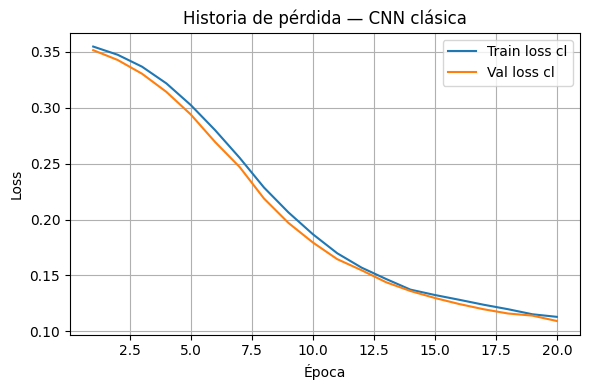

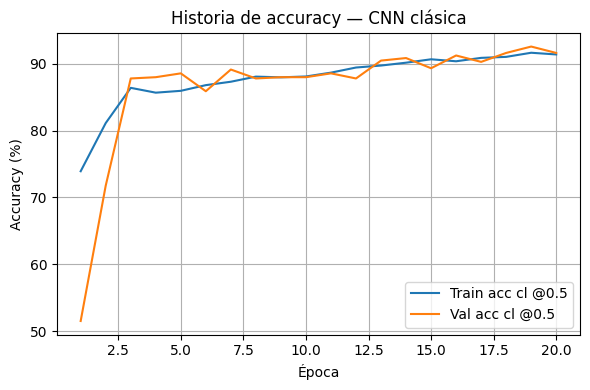

In [15]:
# Restaurar mejor estado clásico
if best_state_cl is not None:
    classical_model.load_state_dict(best_state_cl)
    classical_model.to(DEVICE)
    print(f"[CLÁSICO] Mejor estado restaurado (val_loss={best_val_loss_cl:.4f}, thr*={best_thr_cl:.3f})")

# Gráficas de historia para el modelo clásico
plt.figure(figsize=(6,4))
plt.plot(epochs_range, history_cl["tr_loss"], label="Train loss cl")
plt.plot(epochs_range, history_cl["va_loss"], label="Val loss cl")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.title("Historia de pérdida — CNN clásica")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_range, [x*100 for x in history_cl["tr_acc05"]], label="Train acc cl @0.5")
plt.plot(epochs_range, [x*100 for x in history_cl["va_acc05"]], label="Val acc cl @0.5")
plt.xlabel("Época"); plt.ylabel("Accuracy (%)"); plt.title("Historia de accuracy — CNN clásica")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

In [16]:
#  TEST DEL MODELO CLÁSICO
@torch.no_grad()
def eval_test_classical(dloader, threshold):
    classical_model.eval()
    all_logits = []
    all_y      = []
    total_loss = 0.0
    total_samples = 0

    for xb, yb in dloader:
        xb = xb.to(DEVICE, non_blocking=True)
        yb = yb.to(DEVICE, non_blocking=True).float()

        logits = classical_model(xb).view(-1)
        loss   = criterion(logits, yb)

        total_loss += loss.item() * xb.size(0)
        total_samples += xb.size(0)

        all_logits.append(logits.detach().cpu())
        all_y.append(yb.detach().cpu())

    avg_loss = total_loss / total_samples
    logits   = torch.cat(all_logits, dim=0).numpy()
    y_true   = torch.cat(all_y,      dim=0).numpy()
    probs    = 1.0 / (1.0 + np.exp(-logits))

    y_hat = (probs >= threshold).astype(int)

    acc  = accuracy_score(y_true, y_hat)
    prec, rec, f1_, _ = precision_recall_fscore_support(
        y_true, y_hat,
        average="binary",
        pos_label=CLASS_POS,
        zero_division=0
    )

    try:
        auc = roc_auc_score(y_true, probs)
    except:
        auc = float("nan")

    try:
        pr_auc = average_precision_score(y_true, probs)
    except:
        pr_auc = float("nan")

    cm = confusion_matrix(y_true, y_hat)
    report = classification_report(y_true, y_hat, digits=3)

    return {
        "loss": avg_loss,
        "acc": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1_,
        "auc": auc,
        "pr_auc": pr_auc,
        "cm": cm,
        "report": report,
        "threshold": threshold,
    }

def print_test_classical(tag, res):
    print(f"\n[{tag}] thr={res['threshold']:.3f}")
    print(f"loss={res['loss']:.4f} | acc={res['acc']*100:.1f}% "
          f"| precision={res['precision']:.3f} | recall={res['recall']:.3f} | F1={res['f1']:.3f}")
    print(f"AUC={res['auc']:.3f} | PR-AUC={res['pr_auc']:.3f}")
    print("Matriz de confusión:\n", res["cm"])
    print("Reporte por clase:\n", res["report"])

# Evaluación en test al umbral 0.5 y al umbral óptimo best_thr_cl
res_cl_05 = eval_test_classical(test_loader, 0.5)
res_cl_ts = eval_test_classical(test_loader, best_thr_cl)

print_test_classical("CLÁSICO @0.5", res_cl_05)
print_test_classical("CLÁSICO @thr*", res_cl_ts)


[CLÁSICO @0.5] thr=0.500
loss=0.2463 | acc=87.3% | precision=0.892 | recall=0.908 | F1=0.900
AUC=0.923 | PR-AUC=0.925
Matriz de confusión:
 [[191  43]
 [ 36 354]]
Reporte por clase:
               precision    recall  f1-score   support

         0.0      0.841     0.816     0.829       234
         1.0      0.892     0.908     0.900       390

    accuracy                          0.873       624
   macro avg      0.867     0.862     0.864       624
weighted avg      0.873     0.873     0.873       624


[CLÁSICO @thr*] thr=0.382
loss=0.2463 | acc=86.2% | precision=0.858 | recall=0.933 | F1=0.894
AUC=0.923 | PR-AUC=0.925
Matriz de confusión:
 [[174  60]
 [ 26 364]]
Reporte por clase:
               precision    recall  f1-score   support

         0.0      0.870     0.744     0.802       234
         1.0      0.858     0.933     0.894       390

    accuracy                          0.862       624
   macro avg      0.864     0.838     0.848       624
weighted avg      0.863     0.86

# **Conclusiones**

**Nota**: Espero para el siguiente nb traer ya el desgloze matemático del proyecto, considero que estos ultimos 2 notebooks han dado buen avance pero creo es mejor idea guardar la gran explicación para el siguiente donde abarcare los 3 proyectos con sus avances. Es por eso que no me he detenido mucho a dar una explicación más a detalle de cada sección como con las otras carpetas. En esta sección daré las conclusiones del modelo con el agregado de la CNN.

## I. Entrenamiento y Validación (QCNN vs CNN clásica).

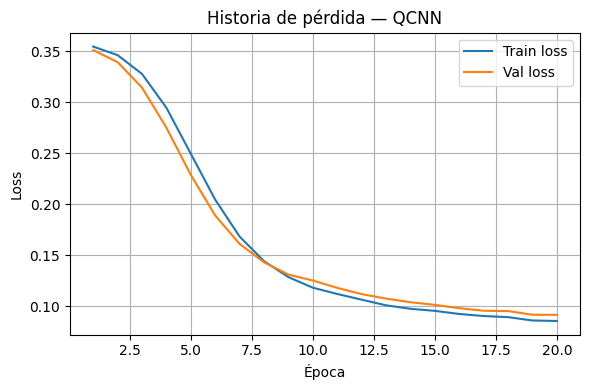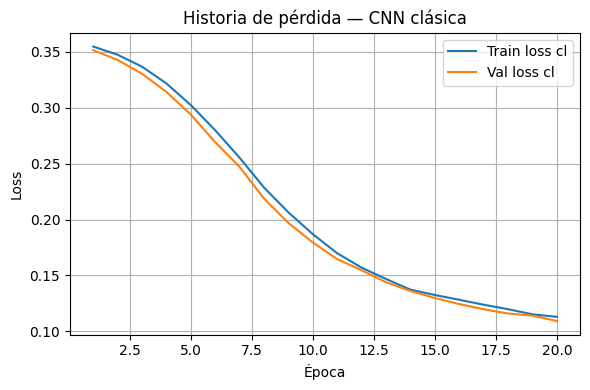

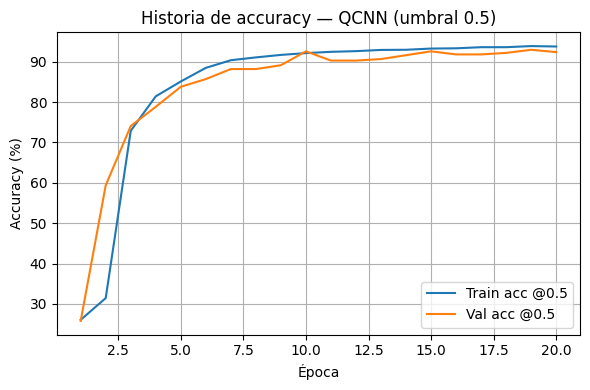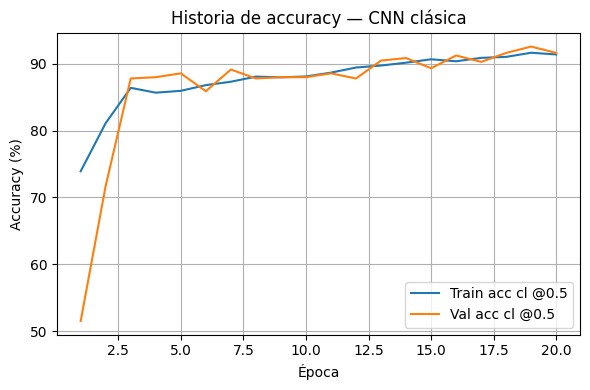

Al comparar las curvas de entrenamiento y validación de ambos modelos, la QCNN y la CNN clásica muestran comportamientos muy similares en términos de convergencia, estabilidad y tendencia general. En ambos casos, la pérdida desciende de manera monotónica, sin picos extraños y sin señales de sobreajuste marcado. Tanto la QCNN como la CNN clásica mantienen curvas de train y validation bastante cercanas entre sí durante todo el proceso, lo que indica que ambos modelos aprenden representaciones relativamente estables para PneumoniaMNIST.

La forma de la caída del loss es prácticamente idéntica en las dos arquitecturas, y mientras la QCNN logra un val_loss ligeramente menor al final (0.0917), esta diferencia no es grande pues la CNN clásica queda un poco arriba al final (0.1093). Lo que si podemos notar es que requiere de menos épocas para lograrlo.

En cuanto a accuracy, ambas arquitecturas alcanzan valores mayores al 90% usando el umbral fijo de 0.5, y ninguna muestra una gran superioridad sólida a lo largo de todas las épocas. La QCNN crece de manera suave y sin oscilaciones grandes, mientras que la CNN clásica sube más rápido en las primeras épocas pero presenta muchsas fluctuaciones. Aun así, ambas terminan con comportamientos prácticamente equivalentes, sin que una domine totalmente y claramente a la otra.

## II. Test (QCNN vs CNN clásica)

Resultados QCNN:
| Métrica       | QCNN @0.5 | QCNN @thr* (0.483) |
| ------------- | --------- | ------------------ |
| **Loss**      | 0.2824    | 0.2824             |
| **Accuracy**  | 88.6 %    | 89.1 %             |
| **Precision** | 0.894     | 0.895              |
| **Recall**    | 0.928     | 0.936              |
| **F1-score**  | 0.911     | 0.915              |
| **AUC**       | 0.923     | 0.923              |
| **PR-AUC**    | 0.912     | 0.912              |
| **TP**        | 362       | 365                |
| **FP**        | 43        | 43                 |
| **FN**        | 28        | 25                 |
| **TN**        | 191       | 191                |

Resultados CNN:
| Métrica       | Clásica @0.5 | Clásica @thr* (0.382) |
| ------------- | ------------ | --------------------- |
| **Loss**      | 0.2463       | 0.2463                |
| **Accuracy**  | 87.3 %       | 86.2 %                |
| **Precision** | 0.892        | 0.858                 |
| **Recall**    | 0.908        | 0.933                 |
| **F1-score**  | 0.900        | 0.894                 |
| **AUC**       | 0.923        | 0.923                 |
| **PR-AUC**    | 0.925        | 0.925                 |
| **TP**        | 354          | 364                   |
| **FP**        | 43           | 60                    |
| **FN**        | 36           | 26                    |
| **TN**        | 191          | 174                   |

Aunque ambas arquitecturas muestran un rendimiento sólido, la QCNN obtiene resultados consistentemente superiores al modelo clásico en las métricas más sensibles para problemas médicos: recall, F1-score y accuracy, especialmente cuando se emplea el umbral óptimo aprendido durante la validación.

El primer punto notable es que la QCNN mantiene un recall más alto que la CNN clásica en ambos umbrales. Esto significa que detecta más casos positivos de neumonía, un aspecto particularmente importante en aplicaciones clínicas donde los falsos negativos tienen un costo elevado. A umbral estándar de 0.5, la QCNN logra un recall de 0.928, mientras que la CNN clásica llega a 0.908. Con el umbral óptimo, la QCNN incluso sube a 0.936, mientras que el clásico se queda en 0.933. Aunque la diferencia no es enorme, sí es consistente y siempre a favor del modelo híbrido.

El F1-score también favorece a la QCNN en todos los escenarios. Con el umbral de 0.5, la QCNN obtiene 0.911 contra 0.900 del modelo clásico, y ajustando el umbral alcanza 0.915, su mejor desempeño. Esto confirma que el equilibrio entre precision y recall es ligeramente mejor en el modelo con capa cuántica. En términos de accuracy global, el comportamiento es similar: la QCNN se mantiene en torno a 88.6–89.1%, mientras que el modelo clásico oscila entre 86–87%.

Respecto a AUC y PR-AUC, ambos modelos empatan prácticamente en ROC-AUC con 0.923, aunque el clásico obtiene un PR-AUC apenas mayor (0.925 vs 0.912 en la QCNN). Esto indica que, en términos de ranking de probabilidades, ninguno de los dos tiene una ventaja significativa sobre el otro; son muy similares. La diferencia aparece realmente cuando se traducen estas probabilidades en decisiones binaria: allí la QCNN conserva más recalls y F1-scores.

Estos resultados muestran que, aunque la QCNN no domina completamente al modelo clásico en todas las métricas, sí lo supera de forma consistente en aquellas que importan más para la tarea de clasificación binaria en un contexto médico.

## III. Canales cuánticos y evolución de parámetros.

Al observar las últimas épocas, los canales 0,1,2 y 3 presentan patrones visualmente distintos, lo cual es esperable porque cada qubit acumula una secuencia diferente de rotaciones y CNOTs. Aún no tengo certeza pero de vista podemos ver que:

* 0 - Atenúa zonas oscuras, hay un buen realce de sombras en los pulmones.
* 1 - Representación más homogénea y conserva bordes principales y mejor definidos.
* 2 - Mayor contraste en región central del tórax.
* 3 - Tiende a saturar zonas brillantes, me parece que detecta patrones intensos

Realemnte debo estudiar más esto, no era el objetivo tal cuál de este notebook pero es importante empezar a trabjarlo desde ahora. 

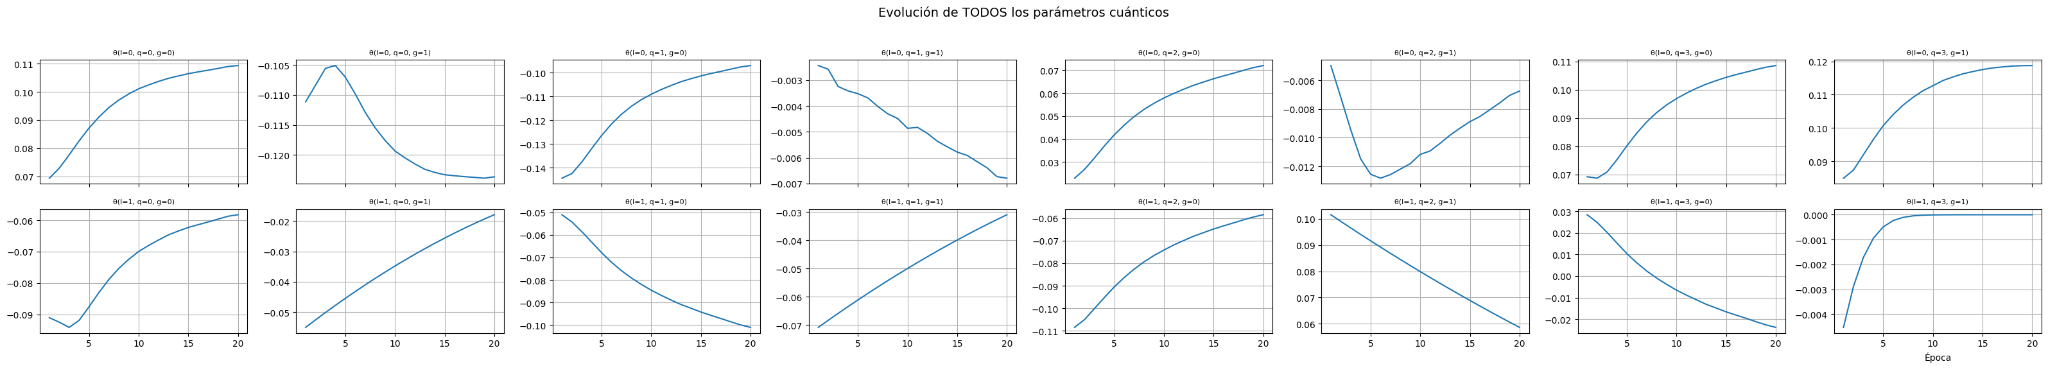

Al analizar los canales cuánticos a lo largo del entrenamiento, se ve claramente que el circuito no está generando ruido ni patrones aleatorios. En las primeras épocas algunos de los pesos todavía no tienen tendencía fija y tienen variación local, pero conforme avanza el entrenamiento empiezan a aparecer caminos más estables. Cada parámetro evoluciona de manera continua y sin brincos bruscos. Algunos suben, otros bajan, pero todos siguen una trayectoria bastante suave desde el inicio hasta la época 20. No hay comportamientos raros como explosiones, temblores, o cambios repentinos de dirección. Esto quiere decir que el entrenamiento sí está encontrando gradientes útiles y que el modelo no se está “atascando” ni perdiendo estabilidad.

En mi siguiente proyecto expondré una idea para ver si funciona mejor que este ansatz sencillo. Recordemos que este VQA lo empecé a utilizar en mi carpeta 2, pues mi finalidad había sido realizar las Quanvoluciones 2x2 y fue la forma de resolverlo. Ahora ya con GPU y con NN y CNN agregadas rapidamente, puedo explorar sin problemas los efectos de estás partes cuánticas. 